# Part 2. Analysis using machine learning techniques

## 1. Prepare data

Firstly, I load the main dataset, which I have cleaned before for my master's thesis research. Please note that "facility" simply means firm.

In [1]:
# Load main emissions data
data = spark.read.csv("s3://noaadata/emissions.csv", header=True, inferSchema=True)
print('Total Rows: %d' % data.count())
data.printSchema()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1591669218971_0004,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Rows: 15069
root
 |-- facility_id: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- facilityname: string (nullable = true)
 |-- state: string (nullable = true)
 |-- county: string (nullable = true)
 |-- participant: integer (nullable = true)
 |-- net_purchase: integer (nullable = true)
 |-- I_purchase: integer (nullable = true)
 |-- I_sell: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- NOx: double (nullable = true)
 |-- operating_time: double (nullable = true)
 |-- heat_input: double (nullable = true)
 |-- n_units: double (nullable = true)
 |-- Ammo_Injection: integer (nullable = true)
 |-- Steam_Injection: integer (nullable = true)
 |-- Water_Injection: integer (nullable = true)
 |-- Catal_Reduction: integer (nullable = true)
 |-- Non_Reduction: integer (nullable = true)
 |-- Comb_Mod: integer (nullable = true)
 |-- Overfire: integer (nullable = true)
 |-- Low_Burner: integer (nullable = true)
 

Next I will explain the definitions of some key variables. The "net_purchase" variable indicates the net amount of allowances purchased by the facility in the given year. If this variable is negative, it means that the facilitiy sold the corresponding amount of allowances in that year. The "I_purchase" variable is an indicator of whether a facility purchased a positive amount in a given year. The "buyer" variable is an indicator of whether a facility has ever purchased a positive amount for any year during the post intervention period. Therefore this variable does not vary by time. Based on standard economic theory, I will only use pre-period characteristics for the prediction analysis, so the "buyer" variable will be the dependent variable. I will apply machine learning techniques to predict a facility's likelihood of being a buyer using various baseline characteristics.

In [2]:
# Take a look at the data and delete missing values
data[['facility_id','year','latitude','longitude','net_purchase','I_purchase','I_sell',
      'buyer','seller','female_ratio','fuel_type','median_income']].show(20)
data = data.dropna()
print('Total Rows: %d' % data.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----+---------+----------+------------+----------+------+-----+------+------------+---------+-------------+
|facility_id|year| latitude| longitude|net_purchase|I_purchase|I_sell|buyer|seller|female_ratio|fuel_type|median_income|
+-----------+----+---------+----------+------------+----------+------+-----+------+------------+---------+-------------+
|          1|2003|31.006901|  -88.0103|           0|         0|     0|    0|     1|  0.51966625|     Coal|        32850|
|          1|2004|31.006901|  -88.0103|           0|         0|     0|    0|     1|  0.51966625|     Coal|        33191|
|          1|2005|31.006901|  -88.0103|           0|         0|     0|    0|     1|  0.51966625|     Coal|        36143|
|          1|2006|31.006901|  -88.0103|           0|         0|     0|    0|     1|  0.51966625|     Coal|        38188|
|          1|2007|31.006901|  -88.0103|           0|         0|     0|    0|     1|  0.51966625|     Coal|        37575|
|          1|2008|31.006901|  -8

Next, I load the grid-cell based weather conditions data, collected from PRISM (https://prism.oregonstate.edu/explorer/). Please note that variable "Name" is the same as "facility_id" in the emissions dataset I just loaded. Then I merge the weather data with the emissions data.

In [3]:
# Load weather data
weather = spark.read.csv("s3://noaadata/weather*.csv", header=True, inferSchema=True)
print('Total Rows: %d' % weather.count())
weather.printSchema()
weather = weather.dropna()
print('Total Rows: %d' % weather.count())
weather.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Rows: 19276
root
 |-- Name: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Elevation: integer (nullable = true)
 |-- Date: integer (nullable = true)
 |-- prcp: double (nullable = true)
 |-- tmin: double (nullable = true)
 |-- tmean: double (nullable = true)
 |-- tmax: double (nullable = true)
 |-- dtmean: double (nullable = true)
 |-- vdpmin: double (nullable = true)
 |-- vdpmax: double (nullable = true)

Total Rows: 17796
+----+---------+--------+---------+----+-----+----+-----+----+------+------+------+
|Name|Longitude|Latitude|Elevation|Date| prcp|tmin|tmean|tmax|dtmean|vdpmin|vdpmax|
+----+---------+--------+---------+----+-----+----+-----+----+------+------+------+
| 501|   -98.17| 44.3696|     1286|2003|18.83|34.0| 46.0|58.0|  34.2|   0.8| 13.22|
| 501|   -98.17| 44.3696|     1286|2004|29.05|34.9| 46.4|57.9|  35.7|  0.64|  11.3|
| 501|   -98.17| 44.3696|     1286|2005|23.39|35.7| 47.5|59.3|  35.4|  0.96| 13.11

In [4]:
# Merge
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
sqlContext.registerDataFrameAsTable(weather, "myTable")
weather = sqlContext.sql("SELECT Name AS facility_id, Date as year, Elevation as elevation, prcp as prcp, tmean as tmean, dtmean as dtmean from myTable")
data = data.join(weather, on=['facility_id','year'], how='left_outer')
print('Total Rows: %d' % data.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Rows: 15014

## 2. Data investigation and visualization
Before running the machine learning algorithms, I will make some tables and plots in order to have a better sense of the data patterns.

In [5]:
sc.install_pypi_package("seaborn")
sc.install_pypi_package("pandas")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/c7/e6/54aaaafd0b87f51dfba92ba73da94151aa3bc179e5fe88fc5dfb3038e860/seaborn-0.10.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a4/5f/1b6e0efab4bfb738478919d40b0e3e1a06e3d9996da45eb62a77e9a090d9/pandas-1.0.4-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/dd/82/c1fe128f3526b128cfd185580ba40d01371c5d299fcf7f77968e22dfcc2e/scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached 

Firstly, I count the number of observations by different groups. The variable "participant" refers to whether a facility is participating in the CAIR program. As I am only interested in participants' trading behaviors, I will limit the analysis to participants. As explained before, I also limit the sample to pre-period only. We can see that the number of observations for buyers and non-buyers is in general balanced, so I will not perform any re-scaling of the sample.

In [6]:
# Count number of observations by participant status
(data.groupBy('participant')
     .count()
     .show()
)

# Count number of observations by buyer status within participants
(data.filter('participant==1').groupBy('buyer')
     .count()
     .show()
)

# Count number of observations by buyer status within participants, pre-period only
(data.filter('participant==1').filter('year<=2008').groupBy('buyer')
     .count()
     .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----+
|participant|count|
+-----------+-----+
|          1|11271|
|          0| 3743|
+-----------+-----+

+-----+-----+
|buyer|count|
+-----+-----+
|    1| 6141|
|    0| 5130|
+-----+-----+

+-----+-----+
|buyer|count|
+-----+-----+
|    1| 2776|
|    0| 2361|
+-----+-----+

I also show the following tables of fuel type and unit type, as they are important categorical variables.

In [7]:
# Count number of observations by fuel type and unit type
(data.groupBy('fuel_type','buyer')
     .count()
     .show()
)
(data.groupBy('unit_type','buyer')
     .count()
     .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+-----+
|fuel_type|buyer|count|
+---------+-----+-----+
|    Other|    1|   34|
|      Gas|    0| 6056|
|      Gas|    1| 3069|
|      Oil|    1|  346|
|     Coal|    0| 2362|
|    Other|    0|   81|
|      Oil|    0|  374|
|     Coal|    1| 2692|
+---------+-----+-----+

+--------------+-----+-----+
|     unit_type|buyer|count|
+--------------+-----+-----+
|       Turbine|    1| 1626|
|        Boiler|    1| 3336|
|Combined cycle|    1| 1179|
|       Turbine|    0| 2207|
|Combined cycle|    0| 2483|
|        Boiler|    0| 4183|
+--------------+-----+-----+

Next, I plot the yearly average emissions level by participant status. We can see that before 2009, the participants group had a much higher emissions level than the non-participants (control) group. However, the emissions level dropped significantly in the participants group in 2009, while non-participants group's emissions trend was stable across all 12 years. This pattern indicates that the CAIR program effectively helped to reduce NOx emissions.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

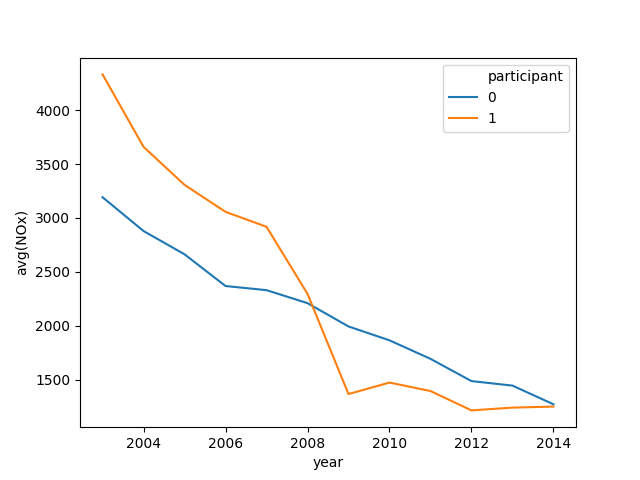

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Average emissions, by participant and year
emission = (data.groupBy('year','participant')
                  .mean('NOx')
                  .sort('year', ascending=True)
              )
df = emission.toPandas()

# Graph
plt.close()
sns.lineplot(x = "year", y = "avg(NOx)", hue='participant', data = df)
%matplot plt

I also plot the emissions level by buyers and non-buyers within participants group. We can see that while their baseline emissions level are quite different, both groups followed the same trend in emissions reduction. This pattern implies that trading activity probably has little impact on emissions reduction level.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

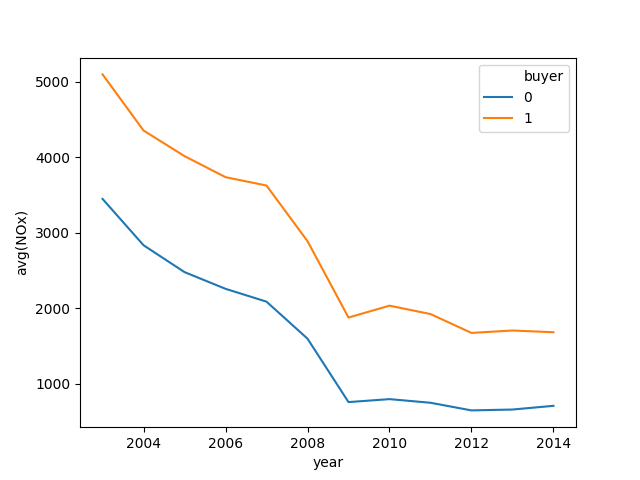

In [9]:
# Average emissions, by participant and year
emission = (data.filter('participant==1').groupBy('year','buyer')
                  .mean('NOx')
                  .sort('year', ascending=True)
              )
df = emission.toPandas()

# Graph
plt.close()
sns.lineplot(x = "year", y = "avg(NOx)", hue='buyer', data = df)
%matplot plt

## 3. Training machine learning models
In this section, since the dependent variable is binary, I will use some different classifying methods, including logistic regression, decision tree, gradient-boosted tree, and random forest. I build a pipeline for each of the four methods.

In [10]:
from pyspark.ml.feature import StringIndexer,OneHotEncoderEstimator,VectorAssembler
from pyspark.ml.classification import LogisticRegression,DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline

# Create dummies for categorical variable
indexer = StringIndexer(inputCol='fuel_type', outputCol='fuel_idx')
indexer2 = StringIndexer(inputCol='unit_type', outputCol='unit_idx')
indexer3 = StringIndexer(inputCol='state', outputCol='state_idx')
onehot = OneHotEncoderEstimator(inputCols=['fuel_idx','unit_idx','state_idx'], outputCols=['fuel_dummy','unit_dummy','state_dummy'])

# Assemble features
features = ['NOx','operating_time','heat_input','n_units','Ammo_Injection','Steam_Injection','Water_Injection',
           'Catal_Reduction','Non_Reduction','Comb_Mod','Overfire','Low_Burner','urban_ratio','pop_den',
           'edu_2','edu_3','edu_4','age_2','age_3','poverty_ratio','white_ratio','black_ratio','median_income',
           'fuel_dummy','unit_dummy','state_dummy','elevation','prcp','tmean','dtmean']
assemble = VectorAssembler(
inputCols= features,
outputCol='features')

# Specify methods
logit = LogisticRegression(featuresCol='features', labelCol='buyer')
tree = DecisionTreeClassifier(featuresCol='features',labelCol='buyer')
bt = GBTClassifier(featuresCol='features',labelCol='buyer')
rf = RandomForestClassifier(featuresCol='features',labelCol='buyer')

# Build pipelines
pipeline1 = Pipeline(stages=[indexer, indexer2, indexer3, onehot, assemble, logit])
pipeline2 = Pipeline(stages=[indexer, indexer2, indexer3, onehot, assemble, tree])
pipeline3 = Pipeline(stages=[indexer, indexer2, indexer3, onehot, assemble, bt])
pipeline4 = Pipeline(stages=[indexer, indexer2, indexer3, onehot, assemble, rf])

# Limit analysis within CAIR participants for the pre-period
sample = data.filter('participant==1').filter('year<2009')

# Split data
train, test = sample.filter('participant==1').randomSplit([0.7, 0.3])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Then I build a cross validator for logistic regression and evaluate the model on test data. The result indicates that the AUC is just above 0.8, meaning that the performance is good.

In [11]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np

# Create parameter grid
params = ParamGridBuilder().addGrid(logit.regParam, [0.001, 0.005, 0.01, 0.05, 0.1, 1]) \
                           .addGrid(logit.elasticNetParam, [0,1]).build()

# Create evaluator
evaluator = BinaryClassificationEvaluator(labelCol='buyer')

# Create cross-validator
cv1 = CrossValidator(estimator=pipeline1, estimatorParamMaps=params, evaluator=evaluator, numFolds=5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# Evaluate AUC on test data
cv = cv1.setSeed(2).fit(train)
best_model = cv.bestModel
predictions = best_model.transform(test)
evaluator.evaluate(predictions)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-12:
Traceback (most recent call last):
  File "/emr/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/emr/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/emr/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 1182



0.7871625885157398

In [13]:
# List coefficients
print(features)
print(str(best_model.stages[5].coefficientMatrix))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['NOx', 'operating_time', 'heat_input', 'n_units', 'Ammo_Injection', 'Steam_Injection', 'Water_Injection', 'Catal_Reduction', 'Non_Reduction', 'Comb_Mod', 'Overfire', 'Low_Burner', 'urban_ratio', 'pop_den', 'edu_2', 'edu_3', 'edu_4', 'age_2', 'age_3', 'poverty_ratio', 'white_ratio', 'black_ratio', 'median_income', 'fuel_dummy', 'unit_dummy', 'state_dummy', 'elevation', 'prcp', 'tmean', 'dtmean']
DenseMatrix([[ 6.05295512e-05,  9.54734402e-04, -1.06612932e-04,
               6.80520743e-02, -1.43764102e+00, -2.89384827e-01,
               3.51680943e-02, -6.28706726e-01,  1.51792588e-01,
              -2.44082265e-01,  1.51926357e-01,  3.51680943e-02,
              -2.95236388e-01, -1.17493198e-04,  6.99231697e+00,
               1.85262831e+00,  5.85856845e+00, -6.12992534e-02,
              -6.15797424e-02, -1.61570692e+00,  3.49296055e-01,
               1.23462933e+00, -1.45193421e-05, -4.41099362e-01,
               3.86495985e-01, -3.23163935e-01, -7.61627930e-01,
              -1

Next I build cross validators for tree-based methods and evaluate the models on test data. Among the three methods, gradient-boosted trees achieves the highest accuracy while decision tree has the lowest accuracy.

In [14]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create parameter grid
params = ParamGridBuilder().build()

# Create evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="buyer", predictionCol="prediction", metricName="accuracy")

# Create cross-validator
cv2 = CrossValidator(estimator=pipeline2, estimatorParamMaps=params, evaluator=evaluator, numFolds=5)
cv3 = CrossValidator(estimator=pipeline3, estimatorParamMaps=params, evaluator=evaluator, numFolds=5)
cv4 = CrossValidator(estimator=pipeline4, estimatorParamMaps=params, evaluator=evaluator, numFolds=5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# Evaluate accuracy on test data
cv = cv2.setSeed(2).fit(train)
best_model = cv.bestModel
predictions = best_model.transform(test)
accuracy = evaluator.evaluate(predictions)
print("Decision Tree Accuracy = %g " %  accuracy)
print(best_model.stages[5])

# Evaluate accuracy on test data
cv = cv3.setSeed(2).fit(train)
best_model = cv.bestModel
predictions = best_model.transform(test)
accuracy = evaluator.evaluate(predictions)
print("Gradient-Boosted Tree Accuracy = %g " %  accuracy)
print(best_model.stages[5])

# Evaluate accuracy on test data
cv = cv4.setSeed(2).fit(train)
best_model = cv.bestModel
predictions = best_model.transform(test)
accuracy = evaluator.evaluate(predictions)
print("Random Forest Accuracy = %g " %  accuracy)
print(best_model.stages[5])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Decision Tree Accuracy = 0.667544 
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_3d085a3b4c65) of depth 5 with 33 nodes
Gradient-Boosted Tree Accuracy = 0.82291 
GBTClassificationModel (uid=GBTClassifier_7fd2f1b1b9d1) with 20 trees
Random Forest Accuracy = 0.721527 
RandomForestClassificationModel (uid=RandomForestClassifier_1a547e9cd972) with 20 trees

Exception in thread cell_monitor-15:
Traceback (most recent call last):
  File "/emr/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/emr/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/emr/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 9880

